In [5]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../../')
from mlrefined_libraries import superlearn_library as superlearn
from mlrefined_libraries import math_optimization_library as optlib

# demos for this notebook
plotter = superlearn.sparse_feature_selection_static
optimizers = optlib.optimizers
regress_plotter = superlearn.lin_regression_demos
# static_plotter = superlearn.classification_static_plotter.Visualizer()
cost_functions = superlearn.cost_functions

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
from mlrefined_libraries.superlearn_library import cost_functions as cost_lib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import sklearn

ModuleNotFoundError: No module named 'mlrefined_libraries'

## Problem 1

In [3]:
# This code cell will not be shown in the HTML version of this notebook
def identity(x):
    return x
def standard_normalizer(x):
    scaler = StandardScaler()
    scaler.fit(x)
    x = scaler.transform(x)
    return x
def PCA_sphereing(x):
    x_means = np.mean(x,axis = 1)[:,np.newaxis]
    x_centered = x - x_means
    lam = 10**(-7)
    P = float(x_centered.shape[1])
    Cov = 1/P*np.dot(x_centered,x_centered.T) + lam*np.eye(x_centered.shape[0])
    d,V = np.linalg.eigh(Cov)
    stds = (d[:,np.newaxis])**(0.5)
    x = np.dot(V.T,x - x_means)/stds
    return x
def compare_schemes(x,y,costname,countname,alpha1,alpha2,alpha3,max_its):     
    # parameters for all gradient descent runs
    C = len(np.unique(y))
    if C == 2:
        C-=1
    
    # create initialization
    w = 0.0*np.random.randn(x.shape[0]+1,C)
    
    # gradient descent loop
    cost_histories = []
    count_histories = []
    for transform,alpha_choice in zip([identity,standard_normalizer,PCA_sphereing],[alpha1,alpha2,alpha3]): 
        #### transform input data ####
        # transform data
        x_transformed = transform(x)
        
        #### make cost and misclassification counter based on transformed input ####
        # create cost and counter
        cost = cost_lib.choose_cost(x_transformed,y,costname)
        count = cost_lib.choose_cost(x_transformed,y,countname)
        
        #### run gradient descent ####
        # make run of gradient descent
        weight_history,cost_history = optimizers.gradient_descent(cost,alpha_choice,max_its,w)
        # compute number of misclassifications
        count_history = [count(v) for v in weight_history]
        cost_histories.append(cost_history)
        count_histories.append(count_history)
    return cost_histories,count_histories

In [4]:
from sklearn.datasets import fetch_openml
# import MNIST
x, y = fetch_openml('mnist_784', version=1, return_X_y=True)

# re-shape input/output data
x = x.T
y = np.array([int(v) for v in y])[np.newaxis,:]

print("input shape = " , x.shape)
print("output shape = ", y.shape)

NameError: name 'np' is not defined

In [ ]:
# sample indices
num_sample = 50000
inds = np.random.permutation(y.shape[1])[:num_sample]
x_sample = x[:,inds]
y_sample = y[:,inds]

In [ ]:
# run comparison module above
alpha_orig = 10**(-5);  alpha_standard = 10**(-1); alpha_pca_sphered = 100;  costname = 'multiclass_softmax'; countname = 'multiclass_counter';
max_its = 10
cost_histories,count_histories = compare_schemes(x_sample,y_sample,costname,countname,alpha_orig,alpha_standard,alpha_pca_sphered,max_its)

In [ ]:
# compare cost / count histories
static_plotter = superlearn.classification_static_plotter.Visualizer()
static_plotter.plot_histories(cost_histories,count_histories,start = 1,labels = ['original','standard','sphered'])

## Problem 2

#### 2a)

In [ ]:
import os
from natsort import natsorted, ns
from skimage import io
from PIL import Image
from numpy import linalg
filename = 'yalefaces/'
list_files = os.listdir(filename)
list_files = natsorted(list_files)

image_list = []
for file in list_files:
    img = np.array(Image.open(filename + file))
    img = img.reshape(img.shape[0]*img.shape[1])
    image_list.append(img)

image_list = np.array(image_list)
print(image_list)
# pd.DataFrame(X).dropna(how='all', inplace=True)

In [8]:
num_components = len(image_list)
image_list = np.array(image_list)
mean_vector = np.mean(image_list, axis=0)
mean_images = image_list - mean_vector

In [10]:
cov_mat = np.dot(mean_images, mean_images.T)
eig_values, eigen_vectors = linalg.eig(cov_mat)
eig_vectors = np.dot(mean_images.T, eigen_vectors)
for i in range(eig_vectors.shape[1]):
    eig_vectors[:, i] = eig_vectors[:, i]/linalg.norm(eig_vectors[:, i])
eig_vectors = eig_vectors.astype(float)
eig_values = eig_values.astype(float)

#### 2b)

Total Energy: 47671384877.73614
Energy captured by 0 components: 0.0
Energy captured by 1 components: 0.0
Energy captured by 2 components: 12532687602.441576
Energy captured by 3 components: 18997308612.784523
Energy captured by 4 components: 23595035814.96609
Energy captured by 5 components: 27013807413.578255
Number of components to capture 50% energy: 5


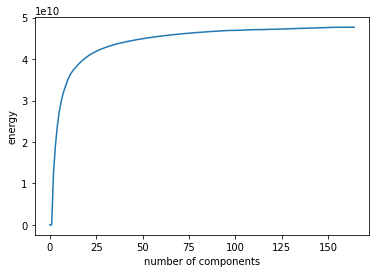

<Figure size 432x288 with 0 Axes>

In [11]:
from numpy import trapz

total_energy = trapz(eig_values, dx=1)
print("Total Energy:", total_energy)

k = 0
while True:
    k_energy = trapz(eig_values[:k], dx=1)
    print("Energy captured by", k, "components:", k_energy)
    if k_energy >= 0.5*total_energy:
        break
    k += 1

print("Number of components to capture 50% energy:", k)
energy_x = []
energy_y = []
for i in range(num_components):
    energy_x.append(i)
    energy_y.append(trapz(eig_values[:i], dx=1))

%matplotlib inline
plt.plot(energy_x, energy_y)
plt.xlabel('number of components')
plt.ylabel('energy')
plt.show()


In [12]:
k_eig_val = eig_values.argsort()[-num_components:][::-1]
eigen_faces = []

for i in k_eig_val:
    eigen_faces.append(eig_vectors[:, i])

eigen_faces = np.array(eigen_faces)
# print(eigen_faces)

In [13]:
plot_faces = []

for i in range(eigen_faces.shape[0]):
#     print(eigen_faces[i].shape)
    plot_faces.append(eigen_faces[i].reshape(243, 320))

plot_faces = np.array(plot_faces)
# print(plot_faces)


#### 2c)

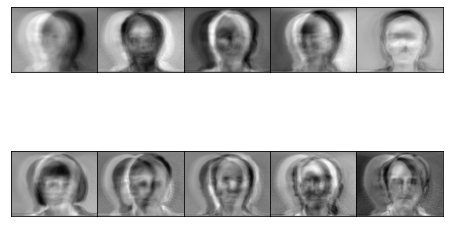

In [14]:
import matplotlib.gridspec as gridspec

images = gridspec.GridSpec(2, 5, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

i = 0
for img in images:
    ax = plt.subplot(img)
    ax.imshow(plot_faces[i], cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1

plt.show()


#### 2d)

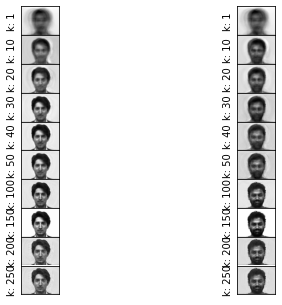

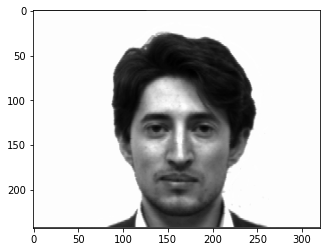

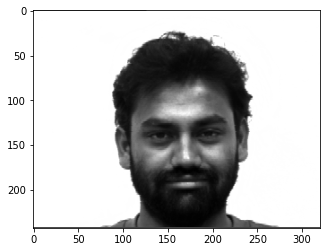

In [15]:
import random

n = np.concatenate(([1, 10, 20, 30, 40, 50, 100, 150, 200, 250], [k]))

r1 = 0
r2 = 0
while r1==r2:
    r1 = random.randint(0, len(mean_images)-1)
    r2 = random.randint(0, len(mean_images)-1)

sample1 = mean_images[r1]
sample2 = mean_images[r2]

outputs = []
for j in n:
    project1 = np.dot(sample1, eigen_faces[:j].T)
    reconstruct1 = np.dot(project1, eigen_faces[:j]) + mean_vector
    outputs.append(reconstruct1)

    project2 = np.dot(sample2, eigen_faces[:j].T)
    reconstruct2 = np.dot(project2, eigen_faces[:j]) + mean_vector
    outputs.append(reconstruct2)

images = gridspec.GridSpec(len(n)-1, 2, top=1., bottom=0., right=1., left=0., hspace=0., wspace=0.)   

i = 0
for img in images:
    ax = plt.subplot(img)
    plt.ylabel("k: "+str(n[int(i/2)]))
    ax.imshow(outputs[i].reshape(243, 320), cmap = plt.get_cmap("gray"))
    ax.set_xticks([])
    ax.set_yticks([])
    i += 1    

plt.show()

plt.imshow(outputs[14].reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()

plt.imshow(outputs[15].reshape(243, 320), cmap = plt.get_cmap("gray"))
plt.show()

By reconstructing the faces, using a varied number of components, we see that we get the best visual result at around 100 - 150 components. Anything above or below that causes the image to blur again.

#### 2e)

In [16]:
filename = 'yalefaces/'
list_files = os.listdir(filename)
list_files = natsorted(list_files)
label_list = []
feature_list = []
image_list = []
for file in list_files:
    img = np.array(Image.open(filename + file))
    label_list.append(file.split('.')[1])
    img = img.reshape(img.shape[0]*img.shape[1])
    image_list.append(img)
    feature_list.append(img)

image_list = np.array(image_list)
# print(image_list)
# print(label_list)
num_components = len(image_list)
# pd.DataFrame(X).dropna(how='all', inplace=True)

In [17]:
# print(len(feature_list))
# print(y)

In [18]:
def cross_validate_single_kernel(X, y, kernel, n_folds, args):
    
    auc = {"C:0.001_gamma:0.001": 0, "C:0.001_gamma:0.01" : 0,"C:0.001_gamma:0.1":0, "C:0.001_gamma:1" : 0,
           "C:0.001_gamma:10": 0, "C:0.001_gamma:100" : 0,"C:0.001_gamma:1000":0, "C:0.001_gamma:1" : 0,
           "C:0.01_gamma:0.001": 0,"C:0.01_gamma:0.01" : 0,"C:0.01_gamma:0.1":0, "C:0.01_gamma:1" :0,"C:0.01_gamma:10" :0,
           "C:0.01_gamma:100" :0, "C:0.01_gamma:1000" :0,"C:0.1_gamma:0.001" :0,"C:0.1_gamma:0.01" :0,
           "C:0.1_gamma:0.1" :0,"C:0.1_gamma:1" :0,"C:0.1_gamma:10" :0 ,"C:0.1_gamma:100" :0,"C:0.1_gamma:1000" :0,
           "C:1_gamma:0.001" :0,"C:1_gamma:0.01" :0,"C:1_gamma:0.1" :0,"C:1_gamma:1" :0,"C:1_gamma:10" :0,"C:1_gamma:100" :0,
           "C:1_gamma:1000" :0,"C:10_gamma:0.001" :0,"C:10_gamma:0.01" :0,"C:10_gamma:0.1" :0,"C:10_gamma:1" :0,
           "C:10_gamma:10" :0,"C:10_gamma:100" :0,"C:10_gamma:1000" :0, "C:100_gamma:0.001" :0,"C:100_gamma:0.01" :0,
           "C:100_gamma:0.1" :0,"C:100_gamma:1" :0,"C:100_gamma:10" :0,"C:100_gamma:100" :0,"C:100_gamma:1000" :0,
           "C:1000_gamma:0.001" :0,"C:1000_gamma:0.01" :0,"C:1000_gamma:0.1" :0,"C:1000_gamma:1" :0,"C:1000_gamma:10" :0,
           "C:1000_gamma:100" :0,"C:1000_gamma:1000" :0}
    skf=StratifiedKFold(n_splits=n_folds, shuffle=True)
    for train_index, test_index in skf.split(X, y):
#         print(args)
#         print("Still running")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()

#         print ("  *")
        ##normalization
        X_train_min, X_train_max = X_train.min(), X_train.max()
        X_train = (X_train - X_train_min)/(X_train_max-X_train_min)
        X_test  = (X_test  - X_train_min)/(X_train_max-X_train_min)

        X_train = X_train[X_train.columns[~(X_train_min==X_train_max)]]
        X_test  = X_test [X_test.columns[~(X_train_min==X_train_max)]]
        for (c_val, gamma_val) in product(args["c_vals"], args["gamma_vals"]):
            svm = SVC(C=c_val, kernel=kernel, tol=1e-7, shrinking=False, gamma=gamma_val)
            svm.fit(X_train, y_train)
            names = "C:%s_gamma:%s"%(c_val, gamma_val)
#             print(names)
            pred   =   svm.predict(X_test)
#             auc[str(names)]  += roc_auc_score(y_test, pred)/n_folds
            auc[str(names)]  += svm.score(X_test,y_test)/num_of_folds
    
    return auc

In [19]:
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from joblib import Parallel, delayed
from itertools import product

num_processes = 30
c_vals = [0.001, 0.1, 1, 10, 100, 1000]
# gamma_vals = np.power(float(10), range(-1, 1+1))
gamma_vals = [0.001, 0.1, 1, 10, 100, 1000]
d_vals     = []
args = {"d_vals":d_vals, "gamma_vals":gamma_vals, "c_vals":c_vals}
num_of_folds = 5
max_iter = 1e8
num_components = [1, 5, 10, 20, 30]
def svm_log(args, num_of_folds,max_iter, kernel, X, y):
    auc_dict  = {'lasso_reg': 0}
    skf=StratifiedKFold(n_splits=num_of_folds, shuffle=True)
    count = 0
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index].values.ravel(), y.iloc[test_index].values.ravel()
        X_train_min, X_train_max = X_train.min(), X_train.max()
        X_train = (X_train - X_train_min)/(X_train_max-X_train_min)
        X_test  = (X_test  - X_train_min)/(X_train_max-X_train_min)

        X_train = X_train[X_train.columns[~(X_train_min==X_train_max)]]
        X_test  = X_test [X_test.columns[~(X_train_min==X_train_max)]]
        pca = PCA(n_components=num_components[count])
#         print("num_components",num_components[count])
        count += 1
        pca.fit(X_train)
        X_train = pca.transform(X_train)
        pca.fit(X_test)
        X_test = pca.transform(X_test)
    #     print(X_train)
        results = cross_validate_single_kernel(pd.DataFrame(X_train), pd.DataFrame(y_train), 'rbf', num_of_folds, args)
        lasso_regressor = Lasso(max_iter = max_iter)
        lasso_regressor.fit(X_train, y_train)

        lasso_pred = lasso_regressor.predict(X_test)

        auc_dict['lasso_reg'] += roc_auc_score(y_test, lasso_pred)/num_of_folds

        
    return auc_dict, results

In [20]:
def combine_max(dict1, dict2):
    keymax = max(dict2, key=dict2.get) 
    dict1[keymax] = dict2[keymax]
    return dict1

In [21]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':1,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
smiling, smiling2 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("smiling", combine_max(smiling, smiling2))

smiling {'lasso_reg': 0.5311111111111111, 'C:0.001_gamma:0.001': 0.9168091168091168}


In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':1,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
glasses, glasses1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("glasses", combine_max(glasses, glasses1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':1, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
happy, happy1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("happy", combine_max(happy, happy1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':1, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
leftlight, leftlight1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("leftlight", combine_max(leftlight, leftlight1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':1, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
noglasses, noglasses1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("noglasses", combine_max(noglasses, noglasses1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':1, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
normal, normal1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("normal", combine_max(normal, normal1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':1, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':0})
rightlight, rightlight1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("rightlight", combine_max(rightlight, rightlight1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':1,
              'sleepy': 0, 'surprised':0, 'wink':0})
sad, sad1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("sad", combine_max(sad, sad1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 1, 'surprised':0, 'wink':0})
sleepy, sleepy1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("sleepy", combine_max(sleepy, sleepy1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':1, 'wink':0})
surprised, surprised1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("surprised", combine_max(surprised, surprised1))

In [ ]:
X = pd.DataFrame(feature_list)
y = pd.DataFrame(label_list)
y = y.replace({'centerlight':0,'glasses':0,'happy':0, 'leftlight':0, 'noglasses':0, 'normal':0, 'rightlight':0, 'sad':0,
              'sleepy': 0, 'surprised':0, 'wink':1})
wink, wink1 = svm_log(args, num_of_folds,max_iter, 'rbf', X, y)
print("wink", combine_max(wink, wink1))